In [1]:
# Authors: 
# - Luigi Frigione < luigi.frigione@studenti.unipd.it >
# - Marco Stefani < marco.stefani.3@studenti.unipd.it > 
# - Edoardo Parpaiola < edoardo.parpaiola@studenti.unipd.it >

import os
import time
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from typing import Self
from scipy import stats
from scipy.stats import norm
from scipy.integrate import quad
from math import ceil, sqrt, prod

# Direct Random Weighted Graphs


### Random Weight
This class is responsible to manage the random edge behaviour

In [2]:
class RandomWeight:

    # IP rw1 first random weight
    # IP rw2 second random weight
    # OR the probability that rw1 <= rw2 assuming independence
    @staticmethod
    def prob_less(rw1 : Self, rw2 : Self) -> float:
        return norm.cdf(0, loc = rw1.mean - rw2.mean, scale = sqrt(rw1.variance + rw2.variance))
    
    # IP a first coefficient
    # IP x1 first random weight
    # IP b second coefficient
    # IP x2 second random weight
    # OR a * x1 + b * x2
    @staticmethod
    def linear_combination(a : float, x1 : Self, b : float, x2 : Self) -> Self:
        return RandomWeight(a * x1.mean + b * x2.mean, sqrt(a**2 * x1.variance + b**2 * x2.variance))

    def __init__(self : Self, mean : float, standard_deviation : float) -> Self:
        self.mean : float = mean
        self.standard_deviation : float = standard_deviation
        self.variance : float = standard_deviation**2

    def __str__(self : Self) -> str:
        return f"N({round(self.mean, 2)}, {round(self.variance, 2)})"

    def sample(self : Self) -> float:
        return np.random.normal(loc = self.mean, scale = self.standard_deviation)
    
    def cdf(self : Self, x : float) -> float:
        return norm.cdf(x, loc = self.mean, scale = self.standard_deviation)

    def pdf(self : Self, x : float) -> float:
        return norm.pdf(x, loc = self.mean, scale = self.standard_deviation)
    
    # IP rw random weight
    # OR the probability that self <= rw assuming independence
    def prob_less_than(self : Self, rw : Self) -> float:
        return Self.prob_less(self, rw)

## Max Formulation

In this section we define two classes that will be used to compute the expectation of the maximum of a set of RandomWeight.  
The *MAX class* computes it by integrating between -inf and +inf.  
The *BoostMAX class* will improve the performance as described in the report.

In [3]:
class MAX:
    def __init__(self, rws : list[RandomWeight]):
        self.random_weights = rws

    def cdf(self, x):
        return prod(rw.cdf(x) for rw in self.random_weights)

    def pdf(self, x):
        return self.cdf(x) * sum((rw.pdf(x) / (rw.cdf(x) + 1e-17))  for rw in self.random_weights)

    def get_expectation(self, lb = -np.inf, ub = np.inf):
        return quad(lambda x: x * self.pdf(x), a = lb, b = ub)
    

class BoostMAX(MAX):
    def __init__(self, rws : list[RandomWeight], threshold_for_single_cdf : float = 0.003, upper_bound_precision: float = 5.0, same_distribution = False):
        super().__init__(rws)
        self.same_distribution = same_distribution
        self.lower_bound = self.calculate_lower_bound(threshold_for_single_cdf)
        self.upper_bound = self.calculate_upper_bound(upper_bound_precision)
    
    def calculate_lower_bound(self, threshold_for_single_cdf): 
        if self.same_distribution:
            return stats.norm.ppf(math.exp(math.log(threshold_for_single_cdf)/len(self.random_weights)), loc=self.random_weights[0].mean, scale=self.random_weights[0].standard_deviation)
        else:       
            return max(stats.norm.ppf(threshold_for_single_cdf, loc=rw.mean, scale=rw.standard_deviation) for rw in self.random_weights)
    
    def calculate_upper_bound(self, upper_bound_precision):
        return max(rw.mean + upper_bound_precision * rw.standard_deviation for rw in self.random_weights)
    
    def get_expectation(self):
        return super().get_expectation(lb=self.lower_bound, ub=self.upper_bound)

### Integration function
Here we visualize the shape of the function we work with

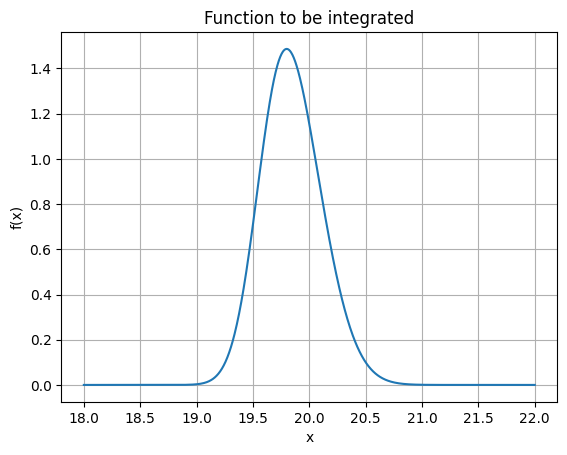

In [4]:
import matplotlib.pyplot as plt

np.random.seed(123)

random_vars = [RandomWeight(np.random.uniform(10,20), np.random.uniform(0.1,0.4)) for i in range(20)]
m = MAX(random_vars)

# Plot the function over the finite range
x_vals = np.linspace(18, 22, 1000)
y_vals = [ m.pdf(x) for x in x_vals]

plt.plot(x_vals, y_vals)
plt.title("Function to be integrated")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid()
plt.show()

### Comparison

In [5]:
start = 2
max_variables = 100
step = 1

exact_results = []
exact_computing_time = []

approximation_results = []
approximation_computing_time = []

n_variables = range(start, max_variables, step)

for n_variable in n_variables:
    
    random_vars = [RandomWeight(np.random.uniform(1,4), np.random.uniform(0.1,0.4)) for i in range(n_variable)]
    
    start_time = time.time()
    mx = BoostMAX(random_vars)
    result, error = mx.get_expectation()
    approximation_results.append(result)
    approximation_computing_time.append(time.time() - start_time)
    
    start_time = time.time()
    mx = MAX(random_vars)
    result, error = mx.get_expectation()
    exact_results.append(result)
    exact_computing_time.append(time.time() - start_time)

/tmp/ipykernel_99411/1306795358.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()


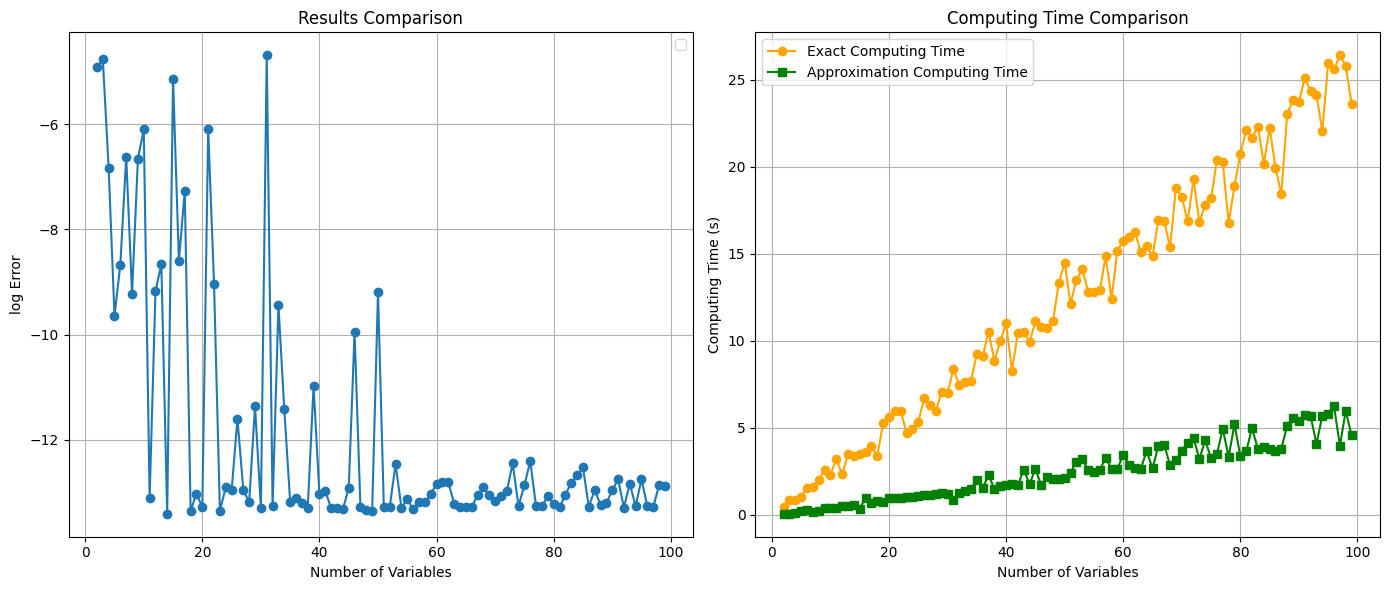

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# exact_results e approximation_results
axes[0].plot(n_variables, np.log(abs(np.array(exact_results) - np.array(approximation_results))), marker='o')
axes[0].set_title('Results Comparison')
axes[0].set_xlabel('Number of Variables')
axes[0].set_ylabel('log Error')
axes[0].legend()
axes[0].grid(True)

# exact_computing_time e approximation_computing_time
axes[1].plot(n_variables, exact_computing_time, label='Exact Computing Time', color = 'orange', marker='o')
axes[1].plot(n_variables, approximation_computing_time, label='Approximation Computing Time', color = 'green', marker='s')
axes[1].set_title('Computing Time Comparison')
axes[1].set_xlabel('Number of Variables')
axes[1].set_ylabel('Computing Time (s)')
axes[1].legend()
axes[1].grid(True)
# print
plt.tight_layout()
plt.show()

# DRWG
This class represents our model

In [7]:
class DRWG:
    
    @staticmethod
    def generate_random(n : int, p : float, seed : int, mean_interval : tuple[float, float], std_interval : tuple[float, float]) -> nx.DiGraph:
        graph : nx.DiGraph = nx.fast_gnp_random_graph(n, p, seed, directed = True)
        
        for u in graph.nodes():
            graph.nodes[u]['label'] = u.__str__()

        for u, v in graph.edges():
            random_mean : float = np.random.uniform(mean_interval[0], mean_interval[1])
            random_std : float = np.random.uniform(std_interval[0], std_interval[1])
            
            rw : RandomWeight = RandomWeight(random_mean, random_std)
            
            graph[u][v]['label'] = rw.__str__()
            graph[u][v]['random_weight'] = rw

        return graph
    
    @staticmethod
    def from_file(file_path: str) -> nx.DiGraph:
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File '{file_path}' does not exist.")
        
        graph : nx.DiGraph = nx.DiGraph()

        graph_data = nx.read_graphml(file_path)
        
        n : int = 0
        node_names = {}

        for curr_u, curr_v, data in graph_data.edges(data = True):
            if not node_names.__contains__(curr_u):
                graph.add_node(n, label = curr_u)
                node_names[curr_u] = n
                n += 1
            
            if not node_names.__contains__(curr_v):
                graph.add_node(n, label = curr_v)
                node_names[curr_v] = n
                n = n + 1
            
            weight = data.get('weight', None)

            if weight is not None:
                mean, stddev = map(float, weight.split('_'))
                rw : RandomWeight = RandomWeight(mean, stddev)
                graph.add_edge(node_names[curr_u], node_names[curr_v], label = rw.__str__(), random_weight = rw)
            else:
                raise ValueError("The edge weight field cannot be None!")
        
        return graph
        
    # Default values
    _N : int = 10
    _P : float = .3
    _MEAN_INTERVAL : tuple[float, float] = (1, 100)
    _STD_INTERVAL : tuple[float, float] = (sqrt(0.1), sqrt(0.4))
    _SEED : int = 2060685 + 2139662 + 2139221
    _TITLE : str = "Graph"
    _FIGSIZE : tuple[float, float] = (10, 10)
    _WITH_LABELS : bool = True
    _EDGE_LABELS : bool = True
    _NODE_COLOR : str = "lightblue"
    _EDGE_COLOR : str = "gray"
    _NODE_SIZE : int = 500
    _FONT_SIZE : int = 10
    _ARROWSIZE : int = 20
    _FONT_COLOR : str = "red"
    _PATH_NODE_COLOR : str = "orange"
    _PATH_EDGE_COLOR : str = "red" 
    _STATIC_TABLE_CELL_WIDTH : int = 16
    
    def __init__(self : Self, n : int = _N, p : float = _P, seed : int = _SEED, file_path = None) -> Self:
        self.graph : nx.DiGraph = self.generate_random(n, p, seed, self._MEAN_INTERVAL, self._STD_INTERVAL) if file_path is None else self.from_file(file_path)

        self.n : int = self.graph.number_of_nodes()
        self.m : int = self.graph.number_of_edges()
        
        # Initializing the path weight estimates (from one node to another) to None for all the node pairs
        self._distance_estimate = np.full((self.n, self.n), None, dtype = RandomWeight)
        
        # Initializing the path weight estimates for all the edges of the graph
        for u, v in self.graph.edges():
            self._distance_estimate[u][v] = self.get_random_weight(u, v)

        # Nodes position layout
        self.layout : nx.Mapping = nx.random_layout(self.graph, seed = self._SEED)

    def plot_graph(self : Self, graph : nx.DiGraph, title : str = _TITLE, figsize : tuple[int, int] = _FIGSIZE, with_labels : bool = _WITH_LABELS, node_color : str = _NODE_COLOR, edge_color : str = _EDGE_COLOR, node_size : int = _NODE_SIZE, font_size : int = _FONT_SIZE, font_color : str = _FONT_COLOR, arrowsize : int = _ARROWSIZE, show_edge_labels : bool = _EDGE_LABELS, isLargeGraph : bool = False) -> None:
        
        if isLargeGraph:
            figsize = (40, 40)
            node_size = 50
            show_edge_labels = False

        # Draws the graph
        plt.figure(figsize = figsize)
        
        # Draws nodes and arcs
        nx.draw(graph, self.layout, with_labels = with_labels, node_color = node_color, edge_color = edge_color, node_size = node_size, font_size = font_size, arrowsize = arrowsize)
        
        nx.draw_networkx_labels(graph, self.layout, labels = nx.get_node_attributes(graph, 'label'))

        # Draws arcs' labels
        if show_edge_labels:
            nx.draw_networkx_edge_labels(graph, self.layout, edge_labels = nx.get_edge_attributes(graph, 'label'), font_color = font_color, font_size = font_size)

        plt.title(title)
        plt.show()

        print(f"Number of vertices: {self.n}")
        print(f"Number of arcs: {self.m}")
    
    def plot(self : Self, title : str = _TITLE, figsize : int = _FIGSIZE, with_labels : bool = _WITH_LABELS, node_color : str = _NODE_COLOR, edge_color : str = _EDGE_COLOR, node_size : int = _NODE_SIZE, font_size : int = _FONT_SIZE, font_color : str = _FONT_COLOR, arrowsize : int = _ARROWSIZE, isLargeGraph : bool = False) -> None:
        self.plot_graph(self.graph, title = title, figsize = figsize, with_labels = with_labels, node_color = node_color, edge_color = edge_color, node_size = node_size, font_size = font_size, font_color = font_color, arrowsize = arrowsize, isLargeGraph = isLargeGraph)

    def sample(self : Self) -> nx.DiGraph:
        sample_graph : nx.DiGraph = nx.DiGraph()
        
        for u, v in self.graph.edges():
            sample : float = self.graph.get_edge_data(u, v)["random_weight"].sample()
            sample_graph.add_edge(u, v, label = round(sample, 2), random_weight = sample, neg_random_weight = -sample)

        for u in sample_graph.nodes():
            sample_graph.nodes[u]['label'] = self.graph.nodes[u]['label']

        return sample_graph

    def weighted_in_degree(self : Self, node : int) -> RandomWeight:
        total_in_degree : RandomWeight = RandomWeight(0,0)

        for u, _ in self.graph.in_edges(node):
            edge_weight : RandomWeight = self.get_random_weight(u, node)
            total_in_degree : RandomWeight = RandomWeight.linear_combination(1, total_in_degree, 1, edge_weight)

        return total_in_degree
        
    def max_weighted_in_degree(self: Self) -> BoostMAX:
        return BoostMAX(rws = [self.weighted_in_degree(n) for n in range(self.n)])

    def weighted_out_degree(self: Self, node : int) -> RandomWeight:
        total_out_degree = RandomWeight(0,0)

        for _, v in self.graph.out_edges(node):
            edge_weight : RandomWeight = self.get_random_weight(node, v)
            total_out_degree : RandomWeight = RandomWeight.linear_combination(1, total_out_degree, 1, edge_weight)

        return total_out_degree

    def max_weighted_out_degree(self: Self) -> BoostMAX:
        return BoostMAX(rws = [self.weighted_out_degree(n) for n in range(self.n)])

    def in_degree(self : Self, node : int) -> int:
        return self.graph.in_degree(node)
    
    def out_degree(self : Self, node : int) -> int:
        return self.graph.in_degree(node)

    def in_edges(self : Self, node : int):
        return self.graph.in_edges(node)
    
    # IP s the source node
    # IP t the target node
    # OR True if there exist an oriented arc between s and t, False otherwise
    def has_edge(self : Self, s : int, t : int) -> bool:
        return self.graph.has_edge(s, t)
    
    def get_edge_data(self : Self, u : int, v : int):
        return self.graph.get_edge_data(u, v)

    def get_random_weight(self : Self, u : int, v : int) -> RandomWeight:
        return self.get_edge_data(u, v)["random_weight"]

    def has_path(self : Self, s : int, t : int) -> bool:
        return nx.has_path(self.graph, s, t)
    
    def plot_path(self, sample, path):

        node_colors = [self._PATH_NODE_COLOR if node in path else self._NODE_COLOR for node in sample.nodes]
        edge_colors = [self._PATH_EDGE_COLOR if (u, v) in zip(path[:-1], path[1:]) else self._EDGE_COLOR for u, v in sample.edges()]

        self.plot_graph(sample, node_color = node_colors, edge_color = edge_colors)

    def translate_path_to_labels(self: Self, path: list[int]) -> list[str]:
        labels = [self.graph.nodes[node].get('label', str(node)) for node in path]
        return labels

    def set_min_estimate(self : Self, i : int, k : int, j : int) -> None:
        # Already initialized
        if i == j:
            return
        # d_ik + d_kj is +inf

        if self._distance_estimate[i][k] is None or self._distance_estimate[k][j] is None:
            return
        
        # here d_ik and d_kj are both not None
        d_new : RandomWeight = RandomWeight.linear_combination(1, self._distance_estimate[i][k], 1, self._distance_estimate[k][j])

        if(self._distance_estimate[i][j] is None):
            self._distance_estimate[i][j] = d_new
            return
        
        # here d_ik, d_kj and d_ij are all not None
        p_new : float = RandomWeight.linear_combination(1, d_new, -1, self._distance_estimate[i][j]).cdf(0)
        
        if p_new > 0.5:
            self._distance_estimate[i][j] = d_new
    
    def floyd_warshall(self : Self) -> None:
        for k in range(self.n):
            for i in range(self.n):
                for j in range(self.n):
                    self.set_min_estimate(i, k, j)

    def print_static_table(self : Self, cell_width = _STATIC_TABLE_CELL_WIDTH) -> None:

        print("Vertices".ljust(cell_width), end="")
        for v in range(self.n):
            node_label = self.graph.nodes[v]["label"]
            print(f"{node_label}".ljust(cell_width), end="")
        print()

        for s in range(self.n):
            source_label = self.graph.nodes[s]["label"]
            print(f"{source_label}".ljust(cell_width), end="")
            for v in range(self.n):
                value = self._distance_estimate[s][v]
                print(f"{value}".ljust(cell_width), end="")
            print()
        print()

    def dynamic_greedy(self: Self, source : int, terminal : int, sample: nx.DiGraph) -> tuple[list[int], float]:
        if(source == terminal):
            print("Source==Terminal")
            return []
        
        if self._distance_estimate[source][terminal] == None:
            raise ValueError("No path available")

        current_node : int = source
        cost = 0
        path = [current_node]

        visited = [False] * self.n

        while(current_node != terminal):
            neighbours = [n for n in sample.successors(current_node)]
            if not neighbours:
                raise ValueError("No path available")
            
            neighbour_to_esaminate = []
            for neighbour in neighbours:
                estimate = self._distance_estimate[neighbour][terminal]

                if visited[neighbour] == False and (neighbour == terminal or estimate is not None):
                    if(neighbour == terminal):
                        neighbour_to_esaminate.append((neighbour, sample.get_edge_data(u = current_node, v = neighbour)["random_weight"]))
                    else:
                        neighbour_to_esaminate.append((neighbour, sample.get_edge_data(u = current_node, v = neighbour)["random_weight"] + estimate.mean))
                    
            if not neighbour_to_esaminate:
                raise ValueError("No path available")
            
            index = np.argmin([neighbour[1] for neighbour in neighbour_to_esaminate])
            
            current_node = neighbour_to_esaminate[index][0]
            visited[current_node] = True
            path.append(current_node)
            cost = cost + sample.get_edge_data(u = path[-2], v = path[-1])["random_weight"]

        return (path, cost)

## Distance estimation
In this section an algorithm to estimate distances among nodes will be developed.  
This estimation can be interpreted as a static analisis of the graph.  
It can be than exploited to perform a dinamic algorithm when an instance is available.  

In the following code blocks we will perform a simple experiment.  
We will generate a random DRWG and then run the static distance estimation algorithm.

In [8]:
G = DRWG(n=6)

G.floyd_warshall()

G.print_static_table()

Vertices        0               1               2               3               4               5               
0               None            N(68.54, 0.41)  N(132.66, 0.6)  N(127.99, 0.42) N(48.0, 0.28)   N(38.95, 0.25)  
1               N(75.87, 0.18)  None            N(208.53, 0.78) N(203.87, 0.6)  N(123.87, 0.46) N(114.82, 0.43) 
2               N(157.62, 0.33) N(81.75, 0.15)  None            N(90.25, 0.38)  N(205.61, 0.61) N(196.57, 0.58) 
3               None            None            None            None            None            None            
4               N(49.31, 0.16)  N(117.86, 0.57) N(181.98, 0.75) N(80.0, 0.14)   None            N(88.26, 0.41)  
5               N(105.47, 0.34) N(29.6, 0.16)   N(93.71, 0.34)  N(183.96, 0.72) N(153.46, 0.62) None            



At this point we sample an istance and we look fo the shortest path with the maximum number of arcs.

In [9]:
sample = G.sample()

tup = ()
length = 0

for u in range(G.n):
    for v in range(G.n):
        if(nx.has_path(sample, u, v)):
            temp = len(nx.shortest_path(sample, u, v, weight="random_weight",  method = 'bellman-ford'))
            if(temp > length):
                length = temp
                tup = (u, v)

print(tup)
print(length)

(1, 2)
4


We compare our algorithm with an exact one.

In [10]:
s, t = tup

# Exact solution
print('Exact solution')
path, cost = nx.shortest_path(sample, s, t, weight = "random_weight", method = 'bellman-ford'), nx.shortest_path_length(sample, s, t, weight = "random_weight", method = 'bellman-ford')
print(path, "\ncost: ", cost)

print()

# Approximation algorithm
print('Approximation algorithm')
path, cost = G.dynamic_greedy(s, t, sample)
print(path, "\ncost: ", cost)

Exact solution
[1, 0, 5, 2] 
cost:  208.4692187384931

Approximation algorithm
[1, 0, 5, 2] 
cost:  208.4692187384931


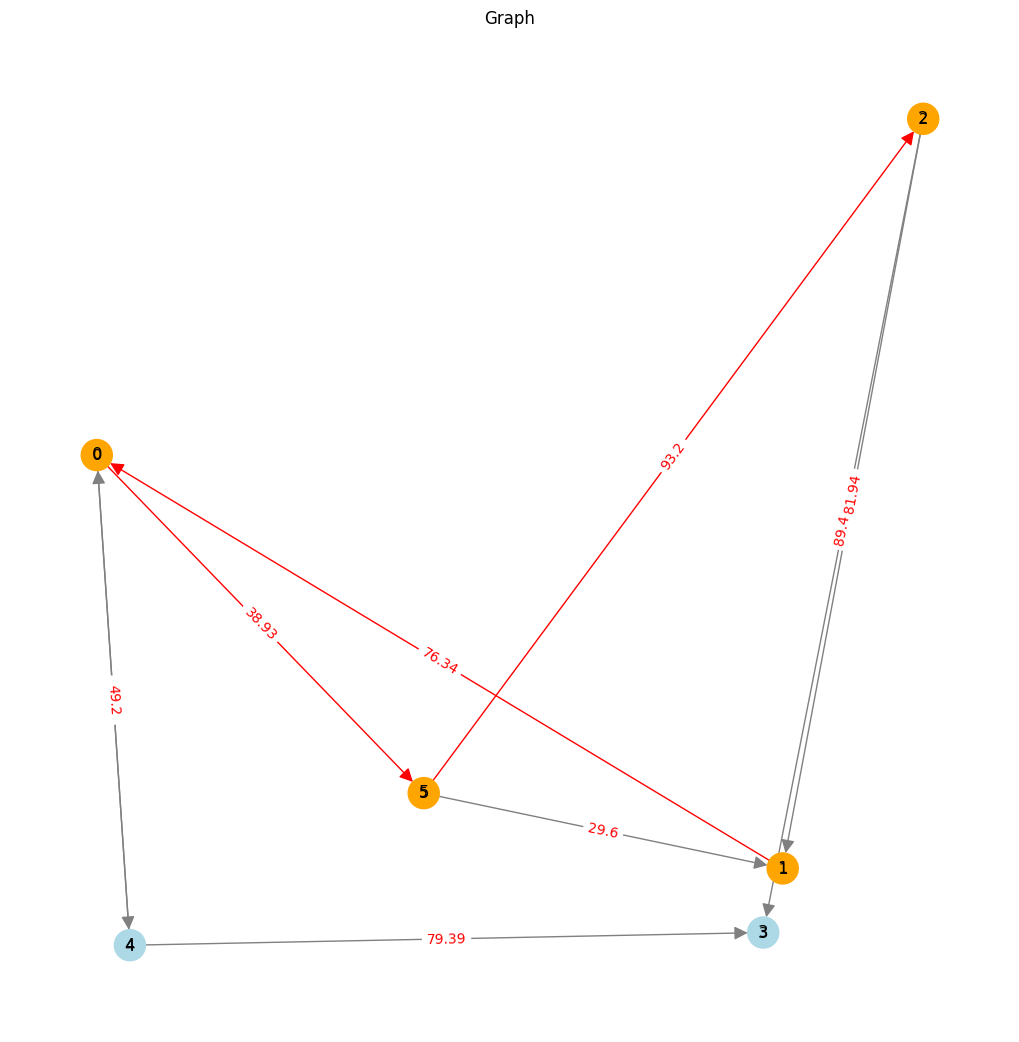

Number of vertices: 6
Number of arcs: 9


In [11]:
G.plot_path(sample, path)

## Binance data
Uploading and generating the graph with real data downloaded from Binance.

In [ ]:
G = DRWG(file_path = './data/01_01_2024.graphml')

G.plot(isLargeGraph = True)

Static analisis

In [ ]:
G.floyd_warshall()

G.print_static_table()

### Experiment 1

We sample an istance and we look for the shortest path with the maximum number of edges.

In [14]:
sample = G.sample()

In [15]:
tup = ()
length = 0

for u in range(G.n):
    for v in range(G.n):
        if(nx.has_path(sample, u, v)):
            temp = len(nx.shortest_path(sample, u, v, weight="random_weight",  method = 'bellman-ford'))
            if(temp > length):
                length = temp
                tup = (u, v)
                
tup_labels = (G.graph.nodes[tup[0]]["label"], G.graph.nodes[tup[1]]["label"])
print(f"Currency pair with the longest path: {tup_labels}")
print(f"Path length: {length}")

Currency pair with the longest path: ('AAVE', 'TRY')
Path length: 6


Compare our greedy algorithm with the exact one (Bellman-Ford since there are negative arcs).

In [16]:
s, t = tup

# Exact solution
print('Exact solution')
path, cost = nx.shortest_path(sample, s, t, weight = "random_weight", method = 'bellman-ford'), nx.shortest_path_length(sample, s, t, weight = "random_weight", method = 'bellman-ford')
print(G.translate_path_to_labels(path), "\ncost: ", cost)
print()

# Approximation algorithm
print('Approximation algorithm')
path, cost = G.dynamic_greedy(s, t, sample)
print(G.translate_path_to_labels(path), "\ncost: ", cost)

Exact solution
['AAVE', 'ETH', 'BTC', 'USDC', 'USDT', 'TRY'] 
cost:  7.89198444441879

Approximation algorithm
['AAVE', 'BTC', 'USDC', 'USDT', 'TRY'] 
cost:  7.896108799484403


### Experiment 2

We analyze the shortest paths among all pairs of vertices (currencies) that are connected by an arc.  
We focus on those with a length (rather than weight) greater than 1.

This indicates that it is possible to exchange directly between these two currencies, but it is not convenient.

In [17]:
sample = G.sample()

Finding shortest paths with length greater than 1.  
We print the maximum gain.

In [18]:
count = 0

max_gain = -1
max_gain_path = []

max_direct_gain = -1
max_opt_gain = -1

for u, v in sample.edges:
    direct_gain = sample[u][v]['label']
    p, opt_gain = nx.shortest_path(sample, u, v, weight = "neg_random_weight", method='bellman-ford'), -nx.shortest_path_length(sample, u, v, weight = "neg_random_weight", method='bellman-ford')
    
    if(len(p) > 2):
        from_label = f"From: {sample.nodes[u]['label']}".ljust(15)
        to_label = f"To: {sample.nodes[v]['label']}".ljust(15)
        exchange_rate_direct = f"Direct exchange rate: {round(np.exp(direct_gain), 2)}".ljust(34)
        exchange_rate_opt = f"Exchange rate: {round(np.exp(opt_gain), 2)}".ljust(30)
        path_labels = f"[{(', '.join([(sample.nodes[curr]['label']).ljust(5) for curr in p]))}]"
        print(f"{exchange_rate_direct}   {from_label}{to_label} → {exchange_rate_opt} Path:  {path_labels}")
        
        count += 1

        if(opt_gain - direct_gain > max_gain):
            max_gain = opt_gain - direct_gain 
            
            max_direct_gain = direct_gain
            max_opt_gain = opt_gain

            max_gain_path = p
        
print(f"Total number of shortest paths with length greater than 1: {count}")

print(''.join(np.repeat('-', 80)))

from_label = f"From: {sample.nodes[max_gain_path[0]]['label']}".ljust(15)
to_label = f"To: {sample.nodes[max_gain_path[-1]]['label']}".ljust(15)
exchange_rate_direct = f"Direct exchange rate: {round(np.exp(max_direct_gain), 2)}".ljust(34)
exchange_rate_opt = f"Exchange rate: {round(np.exp(max_opt_gain), 2)}".ljust(30)
path_labels = f"[{(', '.join([(sample.nodes[curr]['label']).ljust(5) for curr in max_gain_path]))}]"

print(f"{exchange_rate_direct}   {from_label}{to_label} → {exchange_rate_opt} Path:  {path_labels}")

Direct exchange rate: 0.02           From: 1000SATS To: TRY         → Exchange rate: 0.02            Path:  [1000SATS, FDUSD, USDT , TRY  ]
Direct exchange rate: 0.0            From: 1000SATS To: USDT        → Exchange rate: 0.0             Path:  [1000SATS, FDUSD, USDT ]
Direct exchange rate: 29.96          From: FDUSD    To: TRY         → Exchange rate: 30.64           Path:  [FDUSD, USDT , TRY  ]
Direct exchange rate: 668134460.89   From: BTC      To: BIDR        → Exchange rate: 675064542.55    Path:  [BTC  , AEUR , USDT , BIDR ]
Direct exchange rate: 58820441.68    From: BTC      To: NGN         → Exchange rate: 66587869.0      Path:  [BTC  , AEUR , USDT , NGN  ]
Direct exchange rate: 194852.86      From: BTC      To: RON         → Exchange rate: 197403.17       Path:  [BTC  , AEUR , USDT , RON  ]
Direct exchange rate: 1289802.93     From: BTC      To: TRY         → Exchange rate: 1314599.9       Path:  [BTC  , AEUR , USDT , TRY  ]
Direct exchange rate: 1905014.16     From: BTC   